In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap
from statsmodels.tsa.stattools import coint, grangercausalitytests

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda_new.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2021-01-05 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "H1"
instrument = "DE30_EUR"


df1 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df1.iloc[:, 0]).tolist() 

df1.rename(columns={'Close':'Closedf1'}, inplace=True)

In [5]:
start = "2021-01-05 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "H1"
instrument = "IN50_USD"

df2 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df2.iloc[:, 0]).tolist() 

df2.rename(columns={'Close':'Closedf2'}, inplace=True)

In [6]:
df_concat = pd.concat([df1.iloc[:, 3:4], df2.iloc[:, 3:4]], axis=1)
df_concat=df_concat.dropna()

In [7]:
df_concat.reset_index()

,Date,Closedf1,Closedf2
0,2021-01-05T01:00:00,13713.3,14022.8
1,2021-01-05T02:00:00,13728.5,14055.7
2,2021-01-05T03:00:00,13694.7,14092.9
3,2021-01-05T04:00:00,13682.3,14064.5
4,2021-01-05T05:00:00,13706.8,14114.5
...,...,...,...
3322,2021-09-03T15:00:00,15755.8,17385.2
3323,2021-09-03T16:00:00,15768.8,17387.4
3324,2021-09-03T17:00:00,15779.0,17406.6
3325,2021-09-03T18:00:00,15782.0,17406.8


In [8]:
print(df_concat)

                     Closedf1  Closedf2
Date                                   
2021-01-05T01:00:00   13713.3   14022.8
2021-01-05T02:00:00   13728.5   14055.7
2021-01-05T03:00:00   13694.7   14092.9
2021-01-05T04:00:00   13682.3   14064.5
2021-01-05T05:00:00   13706.8   14114.5
...                       ...       ...
2021-09-03T15:00:00   15755.8   17385.2
2021-09-03T16:00:00   15768.8   17387.4
2021-09-03T17:00:00   15779.0   17406.6
2021-09-03T18:00:00   15782.0   17406.8
2021-09-03T19:00:00   15762.2   17396.3

[3327 rows x 2 columns]


<AxesSubplot:xlabel='Date'>

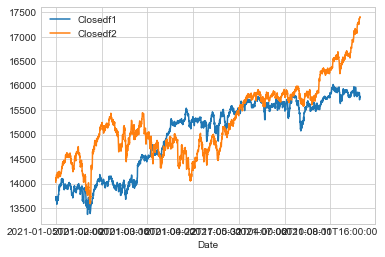

In [9]:
df_concat.plot()

In [10]:
def get_resids(d):
  pca = PCA(1).fit(d.T)
  index=pca.components_[0]
  mm = [sm.OLS(s, index).fit() for s in d.T]
  return list(map(lambda x: x.resid, mm))

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

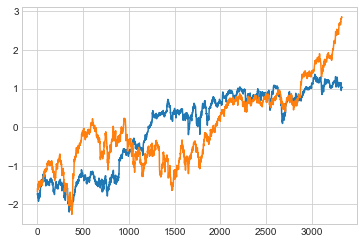

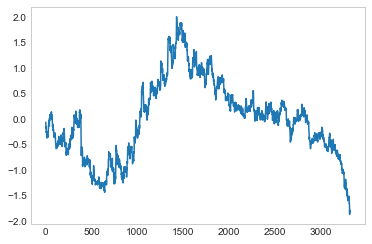

In [11]:
instrument1 = df_concat['Closedf1']
instrument2 = df_concat['Closedf2']
plt.plot(Zscore(instrument1))
plt.plot(Zscore(instrument2))

plt.show()

plt.plot(Zscore(instrument1)-Zscore(instrument2))
plt.grid()

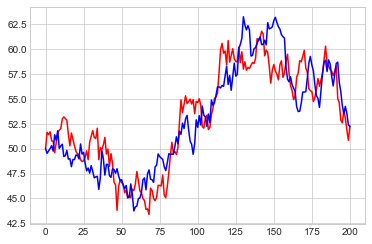

In [12]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

In [13]:
coint(X,Y)

(-4.536726751173016,
 0.001065083076530396,
 array([-3.95203768, -3.36685108, -3.065724  ]))

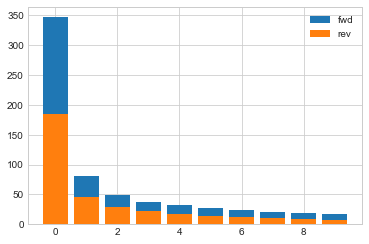

In [14]:
X,Y = make_coint_0(200,T0=[50,50],c=[0.8,0.6])

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags),res_fwd,label='fwd')
plt.bar(range(lags),res_rev,label='rev')
plt.legend()

In [15]:
coints = []
for i in range(df_concat.values.shape[1]):
    for k in range(i,df_concat.values.shape[1]):
        if not i==k:
            coints.append(coint(df_concat.values.T[i],df_concat.values.T[k])[0])

            print(i,k,coints[-1])

0 1 -1.3019456697656209


In [16]:
from sklearn.decomposition import PCA

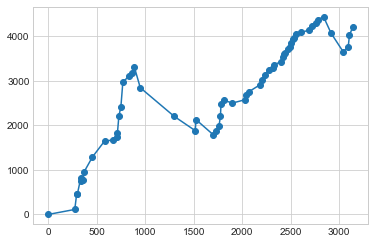

In [17]:
def backtest(instrument1,instrument2,th):
  inpos = 0
  inposlist = [0]
  lkbk = 200
  pnls = [0]
  idxs = [0]
  signallist = [0]
  hedge_ratiolist = [0]

  for i in range(len(instrument1)):
    # GET DATA FROM MARKET
    if i<lkbk:
      continue

    za = Zscore(instrument1[i-lkbk:i])
    zn = Zscore(instrument2[i-lkbk:i])

    signal = za[-1] - zn[-1]
    if not inpos:
      pca = PCA(1).fit(np.array([instrument1[i-lkbk:i],instrument2[i-lkbk:i]]).T)
      hedge_ratio = pca.components_[0,1]/pca.components_[0,0]
      hedge_ratiolist.append(hedge_ratio)
    
    if inpos==0 and signal<-th:
      entry = instrument1[i]*hedge_ratio - instrument2[i] 
      # SEND ENTRY ORDERS TO MARKET
      inpos = 1
      inposlist.append(inpos)
      signallist.append(signal)

    elif inpos>0 and signal>0:
      pnl =  (instrument1[i]*hedge_ratio - instrument2[i]) - entry
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)
      inposlist.append(inpos)
      signallist.append(signal)    

    if inpos==0 and signal>th:
      entry =  instrument1[i]*hedge_ratio - instrument2[i]
      inpos = -1
      inposlist.append(inpos)
      signallist.append(signal)

    elif inpos<0 and signal<0:
      pnl = entry - (instrument1[i]*hedge_ratio - instrument2[i])
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)
      inposlist.append(inpos)
      signallist.append(signal)

  return idxs,pnls, inposlist, signallist, hedge_ratiolist

idxs,pnls, inposlist, signallist, hedge_ratiolist = backtest(instrument1,instrument2,0.6)
plt.plot(idxs,np.cumsum(pnls),'-o');


In [18]:
inposlist[-1]

1

In [19]:
if inposlist[-1] == 1:
    print("LONG A, SHORT B")
    
elif inposlist[-1] == -1:
    print("LONG B, SHORT A")
    
elif inposlist[-1] == 0:
    print("Do nothing right now!")

LONG A, SHORT B


In [20]:
signallist[-1]

-0.7243311144806135

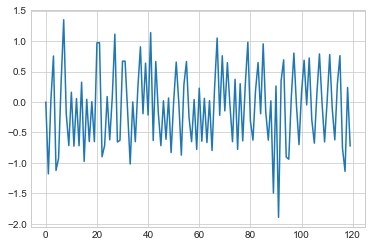

In [21]:
plt.plot(signallist)
plt.show()

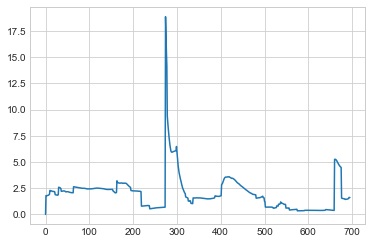

In [22]:
plt.plot(hedge_ratiolist)
plt.show()

In [23]:
hedge_ratiolist[-1]

1.6082604341221591